# Analysis of Retail Sales

## 1.0 Load the required modules
We start off by loading the ipython-sql extension and the python libraries that will enable us run queries on this notebook.

In [1]:
import os
from sqlalchemy import create_engine
from sqlalchemy import inspect
import pandas as pd
import pickle

import visuals_utils as vu


In [2]:
host = os.getenv('HOST')
database = os.getenv('SQL_DATABASE')
user = os.getenv('SQL_USER')
password = os.getenv('SQL_PASSWORD')

## 2.0 Connect to Database

In [3]:
connection_string = f"postgresql://{user}:{password}@{host}/{database}"

In [4]:
engine = create_engine(connection_string)

We can see the names of the tables in the database we connected to.

In [5]:
insp = inspect(engine)
insp.get_table_names()

['product', 'store_cities', 'sales']

## 3.0 Queries

## 3.1.0 Tables in the Database

In [6]:
product_df = pd.read_sql(
    'SELECT * FROM product', engine
)
product_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   product_id      699 non-null    object 
 1   product_length  681 non-null    float64
 2   product_depth   683 non-null    float64
 3   product_width   683 non-null    float64
 4   cluster_id      649 non-null    object 
 5   hierarchy1_id   699 non-null    object 
 6   hierarchy2_id   699 non-null    object 
 7   hierarchy3_id   699 non-null    object 
 8   hierarchy4_id   699 non-null    object 
 9   hierarchy5_id   699 non-null    object 
dtypes: float64(3), object(7)
memory usage: 54.7+ KB


In [7]:
store_cities_df = pd.read_sql(
    'SELECT * FROM store_cities', engine
)
store_cities_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   store_id      144 non-null    object 
 1   storetype_id  144 non-null    object 
 2   store_size    144 non-null    float64
 3   city_id       144 non-null    object 
dtypes: float64(1), object(3)
memory usage: 4.6+ KB


In [8]:
# sales_df = pd.read_sql(
#     'SELECT * FROM sales', engine
# )
# sales_df.info()

In [9]:
# filename = 'sales_df_sqlalchemy.pickle'
# with open(filename, 'wb') as f:
#     pickle.dump(sales_df, f)

In [10]:
# del sales_df

In [11]:
filename = 'sales_df_sqlalchemy.pickle'
with open(filename, 'rb') as f:
    loaded_sales_df = pickle.load(f)

In [12]:
loaded_sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19454838 entries, 0 to 19454837
Data columns (total 13 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   product_id             object 
 1   store_id               object 
 2   date                   object 
 3   sales                  float64
 4   revenue                float64
 5   stock                  float64
 6   price                  float64
 7   promo_type_1           object 
 8   promo_bin_1            object 
 9   promo_type_2           object 
 10  promo_bin_2            object 
 11  promo_discount_2       object 
 12  promo_discount_type_2  object 
dtypes: float64(4), object(9)
memory usage: 1.9+ GB


## 3.2.0 Average Revenue

### 3.2.1 Average revenue for all the stores 

In [13]:
avg_revenue = pd.read_sql(
    'SELECT CAST(AVG(revenue) AS DECIMAL (5,2)) FROM sales', 
    engine)

avg_revenue

,avg
0,2.06


### 3.2.2 Average revenue by store

In [14]:
avg_revenue_by_store = pd.read_sql(
    '''SELECT store_id, CAST(AVG(revenue) AS DECIMAL (5,2)) 
    FROM sales 
    GROUP BY store_id''',
    engine
)
avg_revenue_by_store

,store_id,avg
0,S0001,3.18
1,S0002,2.12
2,S0003,1.90
3,S0004,1.37
4,S0005,1.49
...,...,...
139,S0140,1.29
140,S0141,0.73
141,S0142,0.98
142,S0143,0.86


### 3.2.3 Average revenue for a specified store

### Specify one store_id

In [15]:
store_avg_revenue = pd.read_sql(
    '''
    SELECT * 
    FROM(SELECT store_id, CAST(AVG(revenue) AS DECIMAL (5,2)) 
    FROM sales GROUP BY store_id) AS result 
    WHERE result.store_id = 'S0100'
    ''', engine
)
store_avg_revenue

,store_id,avg
0,S0100,2.65


### Specify two store_ids

In [16]:
select_store_avg_revenue=pd.read_sql(
    '''
    SELECT * 
    FROM(SELECT store_id, CAST(AVG(revenue) AS DECIMAL (5,2)) 
    FROM sales GROUP BY store_id) AS result 
    WHERE result.store_id = 'S0100' OR
            result.store_id = 'S0101'
    ''', engine
)
select_store_avg_revenue

,store_id,avg
0,S0100,2.65
1,S0101,2.41


### Specify a range of store_ids selected from table

In [17]:
select_range_store_avg_revenue = pd.read_sql(
    '''
    SELECT * 
    FROM(SELECT store_id, CAST(AVG(revenue) AS DECIMAL (5,2)) 
    FROM sales GROUP BY store_id) AS result 
    WHERE result.store_id BETWEEN 'S0140' AND 'S0144'
    ''', engine
)
select_range_store_avg_revenue

,store_id,avg
0,S0140,1.29
1,S0141,0.73
2,S0142,0.98
3,S0143,0.86
4,S0144,0.92


## 3.3.0 Revenue by city

### Revenue from each store in each city
Here, we want to identify the revenue from a particular store in a particular city

In [18]:
revenue_by_store_city_id=pd.read_sql(
'''SELECT store_cities.city_id, sales.revenue 
FROM sales INNER JOIN store_cities 
ON sales.store_id=store_cities.store_id''',
engine)

The revenue_by_store_city_id query returned a huge number of rows. We can group the result of the query by city_id but first let's see how unique city_ids we have in the result

In [19]:
len(revenue_by_store_city_id['city_id'].unique())

37

### Revenue from each city

In [20]:
total_revenue_by_city_id=pd.read_sql(
'''SELECT city_id, CAST(SUM(revenue) AS DECIMAL (10,2)) 
FROM sales INNER JOIN store_cities 
ON sales.store_id=store_cities.store_id 
GROUP BY city_id''',
engine
)

In [21]:
total_revenue_by_city_id.head()

,city_id,sum
0,C001,223137.25
1,C002,680987.33
2,C003,103252.45
3,C004,1027630.08
4,C005,417360.83


Which city generated the maximum revenue?

In [22]:
city_max_revenue = pd.read_sql(
    '''SELECT city_id, CAST(SUM(revenue) AS DECIMAL (10,2)) 
    FROM sales INNER JOIN store_cities 
    ON sales.store_id=store_cities.store_id 
    GROUP BY city_id 
    ORDER BY sum DESC 
    LIMIT 1''',
    engine
)
city_max_revenue

,city_id,sum
0,C014,12760439.56


## 3.3.0 Revenue by store

### Revenue from each store_id in the cities where the store_id exists

In [23]:
total_revenue_by_store_id = pd.read_sql(
'''SELECT sales.store_id, city_id, CAST(SUM(revenue) AS DECIMAL 
(10,2)) FROM sales INNER JOIN store_cities ON sales.store_id=
store_cities.store_id GROUP BY sales.store_id, city_id''',
engine)

In [24]:
total_revenue_by_store_id.head()

,store_id,city_id,sum
0,S0001,C031,847042.16
1,S0002,C007,494121.62
2,S0003,C014,132146.69
3,S0004,C022,174120.06
4,S0005,C001,108092.49


Which store in which city generated the maximum revenue? How much is the revenue?

In [25]:
store_max_revenue = pd.read_sql(
    '''
    SELECT sales.store_id, city_id, 
    CAST(SUM(revenue) AS DECIMAL (10,2)) 
    FROM sales 
    INNER JOIN store_cities ON sales.store_id=store_cities.store_id
    GROUP BY sales.store_id, city_id
    ORDER BY sum DESC
    LIMIT 1
    ''', engine
)
store_max_revenue

,store_id,city_id,sum
0,S0085,C014,2156037.86


## 3.3.0 Revenue by product

### Revenue from each product_id

In [26]:
total_revenue_by_product_id = pd.read_sql(
    '''
    SELECT sales.product_id, 
    CAST(SUM(revenue) AS DECIMAL (10,2)) 
    FROM sales INNER JOIN product 
    ON sales.product_id=product.product_id 
    GROUP BY sales.product_id''',
    engine
)
total_revenue_by_product_id.head()

,product_id,sum
0,P0001,21128.44
1,P0002,9776.39
2,P0004,1631.29
3,P0005,25408.62
4,P0006,2550.17


Which product generated the maximum revenue?

In [27]:
product_max_revenue = pd.read_sql(
    '''
    SELECT *
    FROM(SELECT sales.product_id, 
    CAST(SUM(revenue) AS DECIMAL (10,2)) 
    FROM sales 
    INNER JOIN product ON product.product_id=sales.product_id
    GROUP BY sales.product_id
    ORDER BY sum DESC) AS result
    WHERE result.sum IS NOT NULL
    LIMIT 1
    ''', engine
)
product_max_revenue 

,product_id,sum
0,P0103,2670199.66


We can generate a table for the revenue generated for each product

In [28]:
total_revenue_by_product_by_store = pd.read_sql(
    '''SELECT sales.product_id, sales.store_id, CAST(
    SUM(revenue) AS DECIMAL (10,2)) 
    FROM sales 
    INNER JOIN product ON sales.product_id=product.product_id
    GROUP BY sales.product_id, sales.store_id''',
    engine)
    
total_revenue_by_product_by_store.head()

,product_id,store_id,sum
0,P0001,S0001,1616.59
1,P0001,S0002,577.25
2,P0001,S0004,66.79
3,P0001,S0008,129.45
4,P0001,S0010,234.26


Let's find the product that generated the highest revenue looking at the individual stores. We can also identify the store where that product was sold.

In [29]:
product_by_store_max_revenue = pd.read_sql(
    '''SELECT *
    FROM(SELECT sales.product_id, sales.store_id, CAST(SUM(revenue) AS DECIMAL (10,2)) 
    FROM sales 
    INNER JOIN product ON product.product_id=sales.product_id
    GROUP BY sales.product_id, sales.store_id
    ORDER BY sum DESC) AS result
    WHERE result.sum IS NOT NULL
    LIMIT 1''',
    engine)

product_by_store_max_revenue

,product_id,store_id,sum
0,P0103,S0097,278874.15


Visualizations

Visualize top n performers

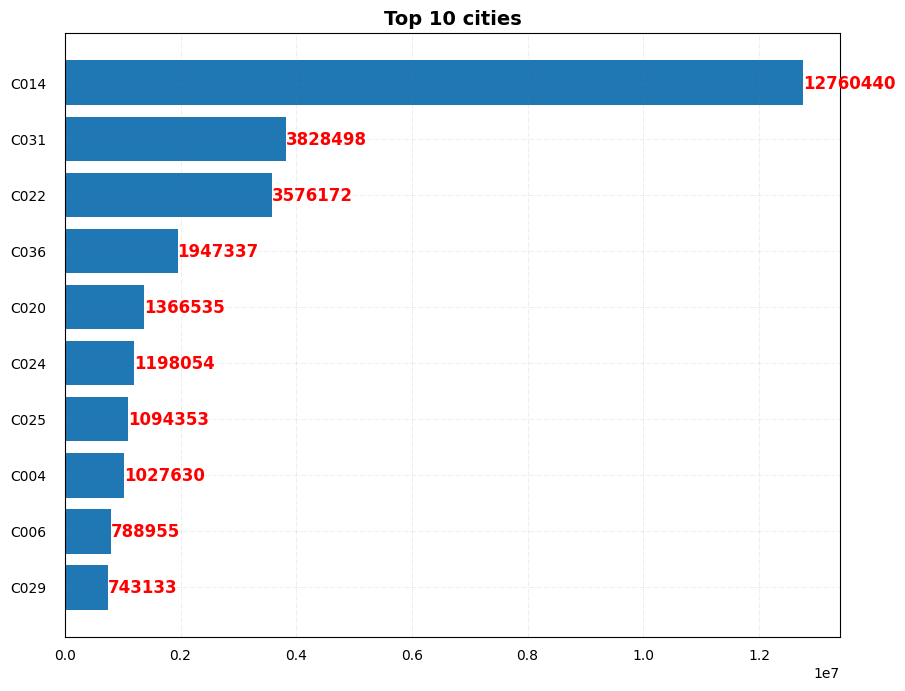

/Users/obikacd/Desktop/sql_sales_analysis/visuals_utils.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.top_df.loc[len(self.df.index)]=[


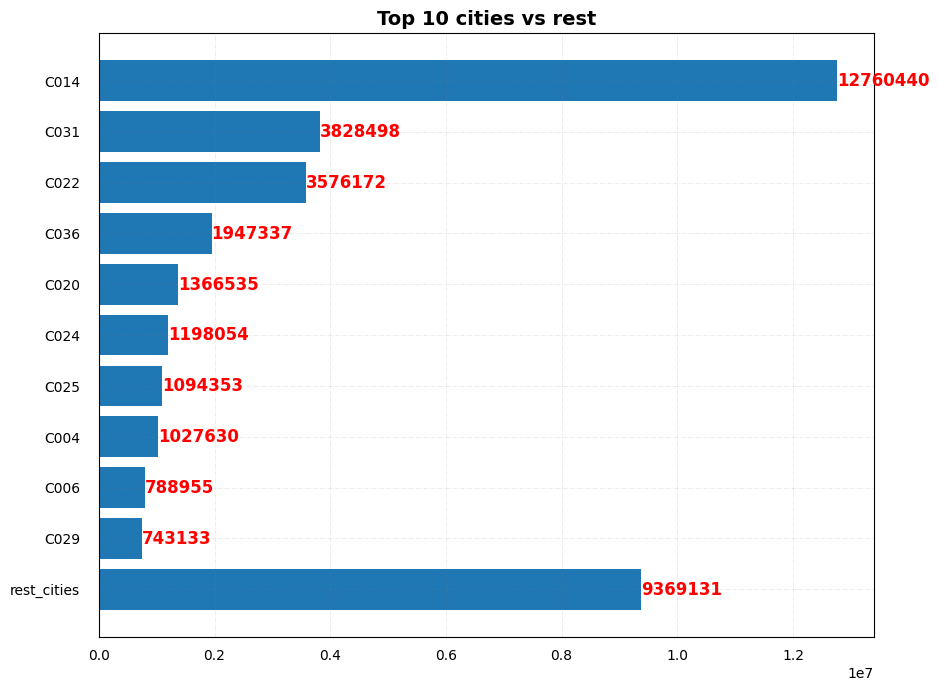

In [30]:
vu.TopPerformers(
    total_revenue_by_city_id
    ).plot_top_n_vs_rest('cities', vs_rest=False)

vu.TopPerformers(
    total_revenue_by_city_id
    ).plot_top_n_vs_rest('cities', vs_rest=True)

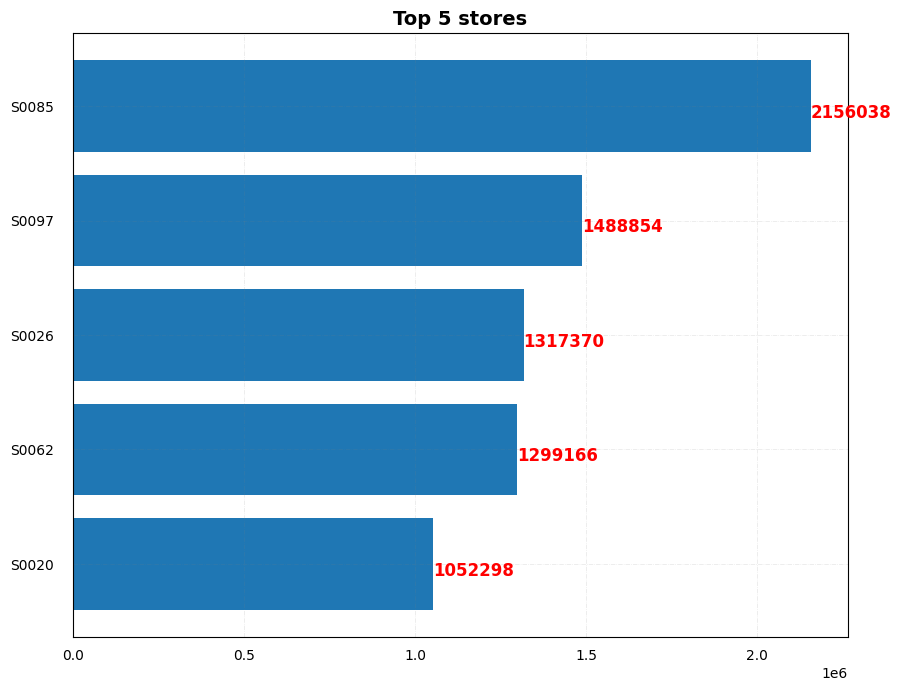

/Users/obikacd/Desktop/sql_sales_analysis/visuals_utils.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.top_df.loc[len(self.df.index)]=[


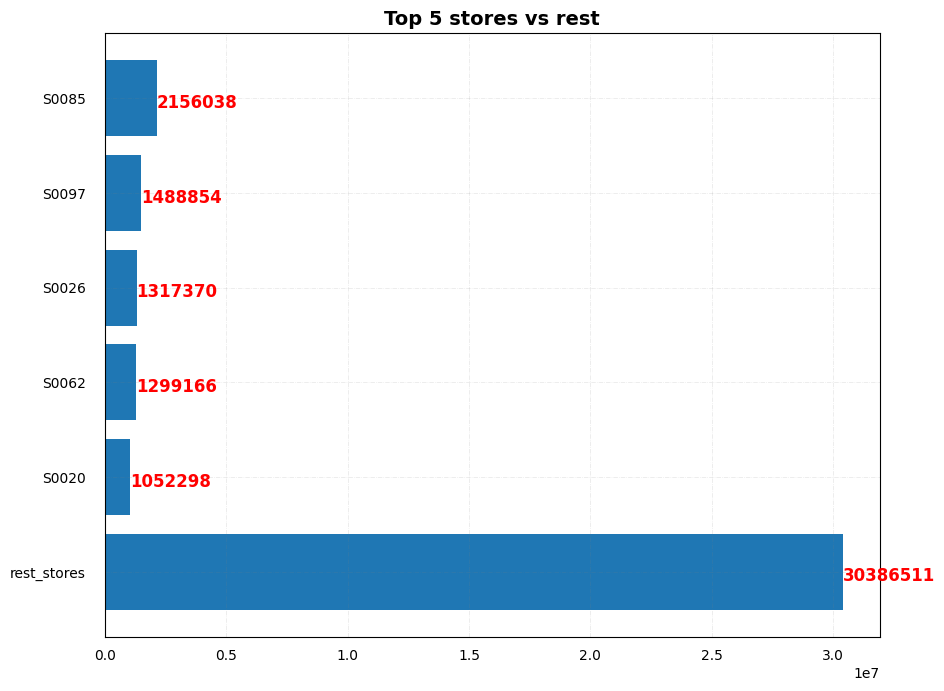

In [31]:
vu.TopPerformers(
    total_revenue_by_store_id, 5
    ).plot_top_n_vs_rest('stores', vs_rest=False)

vu.TopPerformers(
    total_revenue_by_store_id, 5
    ).plot_top_n_vs_rest('stores', vs_rest=True)

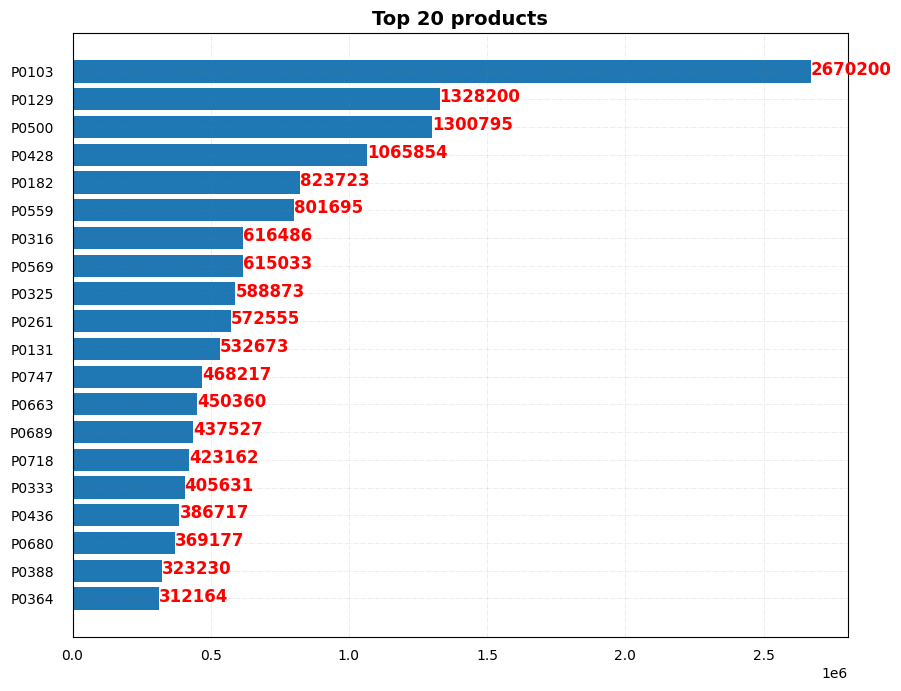

/Users/obikacd/Desktop/sql_sales_analysis/visuals_utils.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.top_df.loc[len(self.df.index)]=[


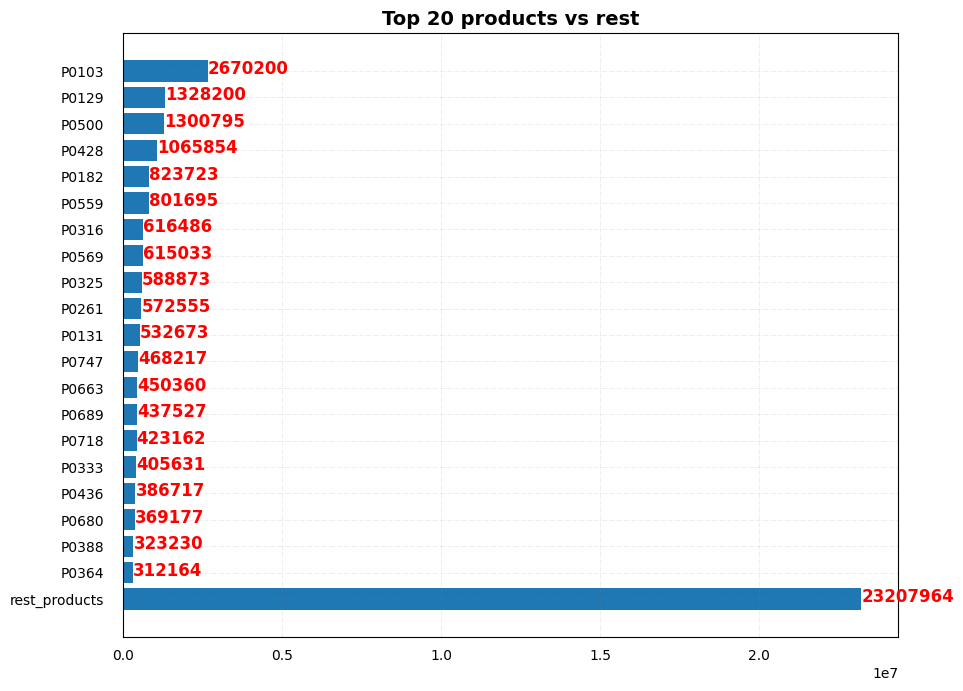

In [32]:
vu.TopPerformers(
    total_revenue_by_product_id, 20
    ).plot_top_n_vs_rest('products', vs_rest=False)
vu.TopPerformers(
    total_revenue_by_product_id, 20
    ).plot_top_n_vs_rest('products', vs_rest=True)